# Initialisation

In [0]:
!pip install GPy

     |████████████████████████████████| 1.0MB 8.2MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633958 sha256=7e802c33e4acc8291478d95db4746de3129d09a18079d3f1d792289cb61fdad9
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=d7948cd7c87c5cd9a0b2ee72818b3d1e45854e2c00b9fc47544879be3f6daeca
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [0]:
!git clone https://github.com/SheffieldML/PyDeepGP.git

Cloning into 'PyDeepGP'...
remote: Enumerating objects: 168, done.
remote: Total 168 (delta 0), reused 0 (delta 0), pack-reused 168
Receiving objects: 100% (168/168), 114.56 KiB | 563.00 KiB/s, done.
Resolving deltas: 100% (80/80), done.


In [0]:
%cd PyDeepGP/

/content/PyDeepGP


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
import deepgp
from keras.datasets import fashion_mnist

Using TensorFlow backend.


# Data importation/visualization/preprocessing

Training set shape:  (800, 28, 28)
Number of classes:  4



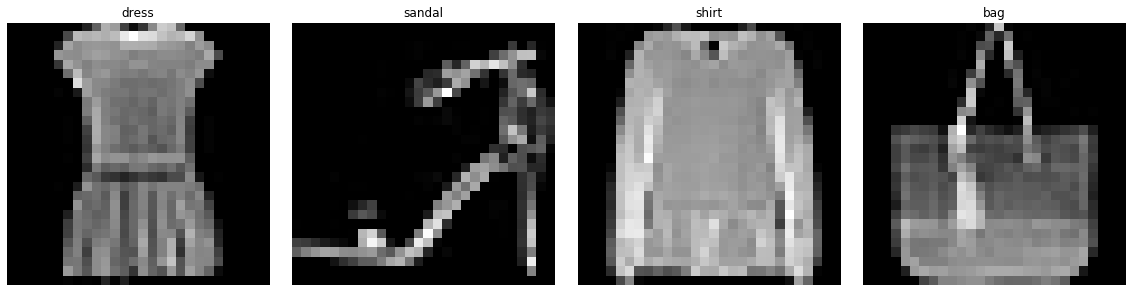

<Figure size 432x288 with 0 Axes>

In [0]:
# Import data
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
x_train = trainX.copy().astype("float32")
y_train = trainY.copy()
x_test = testX.copy().astype("float32")
y_test = testY.copy()

# [0, 1] range
x_train /= 255
x_test /= 255

# Extract 4 classes
n_samples = 200
x1 = x_train[np.where(y_train == 3)][:n_samples]
x2 = x_train[np.where(y_train == 5)][:n_samples]
x3 = x_train[np.where(y_train == 6)][:n_samples]
x4 = x_train[np.where(y_train == 8)][:n_samples]
x_train = np.vstack((x1,x2, x3, x4))
y_train = [0]*n_samples + [1]*n_samples + [2]*n_samples + [3]*n_samples
idx = np.arange(n_samples*4)
np.random.shuffle(idx)
x_train = np.array(list(map(lambda i: x_train[i], idx)))
y_train = list(map(lambda i: y_train[i], idx))

print("Training set shape: ", x_train.shape)
print("Number of classes: ", len(set(y_train)))
print("")

# plot classes
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
axes[0].imshow(x1[0], cmap='gray')
axes[0].set_title('dress')
axes[0].axis('off')
axes[1].imshow(x2[0], cmap='gray')
axes[1].set_title('sandal')
axes[1].axis('off')
axes[2].imshow(x3[0], cmap='gray')
axes[2].set_title('shirt')
axes[2].axis('off')
axes[3].imshow(x4[1], cmap='gray')
axes[3].set_title('bag')
axes[3].axis('off')
fig.tight_layout()
plt.savefig("samples.png")
plt.figure()

# Extract 4 classes
n_samples_test = 100
x1 = x_test[np.where(y_test == 3)][:n_samples_test]
x2 = x_test[np.where(y_test == 5)][:n_samples_test]
x3 = x_test[np.where(y_test == 6)][:n_samples_test]
x4 = x_test[np.where(y_test == 8)][:n_samples_test]
x_test = np.vstack((x1,x2, x3, x4))
y_test = [0]*n_samples_test + [1]*n_samples_test + [2]*n_samples_test + [3]*n_samples_test
idx = np.arange(n_samples_test*4)
np.random.shuffle(idx)
x_test = np.array(list(map(lambda i: x_test[i], idx)))
y_test = list(map(lambda i: y_test[i], idx))

# Flatten inputs
x_train = x_train.reshape((-1, 28*28))
x_test = x_test.reshape((-1, 28*28))

# Modelisation

In [0]:
# Number of latent dimensions per layer
Q1, Q2, Q3, Q4, Q5 = 30, 24, 18, 12, 8

# Type of kernel per layer
kern1 = GPy.kern.RBF(Q1, ARD=True) + GPy.kern.Bias(Q1)
kern2 = GPy.kern.RBF(Q2, ARD=True) + GPy.kern.Bias(Q2)
kern3 = GPy.kern.RBF(Q3, ARD=True) + GPy.kern.Bias(Q3)
kern4 = GPy.kern.RBF(Q4, ARD=True) + GPy.kern.Bias(Q4)
kern5 = GPy.kern.RBF(Q5, ARD=True) + GPy.kern.Bias(Q5)

# Number of inducing points per layer (can be set to different if given as list).
num_inducing = [400, 300, 200, 200, 100]

# Build model
DGP = deepgp.DeepGP([x_train.shape[1], Q1, Q2, Q3, Q4, Q5],
                    x_train,
                    kernels=[kern1, kern2, kern3, kern4, kern5], 
                    num_inducing=num_inducing, 
                    back_constraint=False)

# Make sure initial noise variance gives a reasonable signal to noise ratio
for i in range(len(DGP.layers)):
    output_var = DGP.layers[i].Y.var() if i==0 else DGP.layers[i].Y.mean.var()
    DGP.layers[i].Gaussian_noise.variance = output_var*0.01

In [0]:
# Train model
DGP.optimize(max_iters=1000, messages=True)

In [0]:
# Save model
DGP.save('model_1000')

# Plots

[<BarContainer object of 12 artists>, <BarContainer object of 12 artists>]

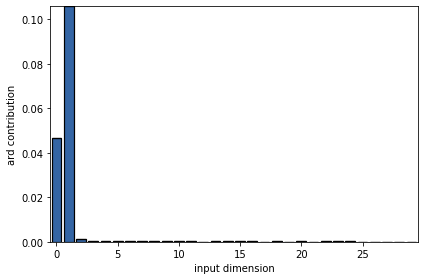

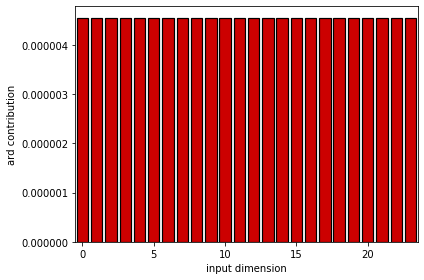

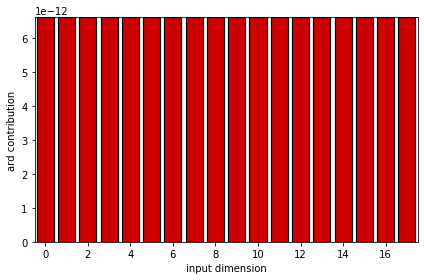

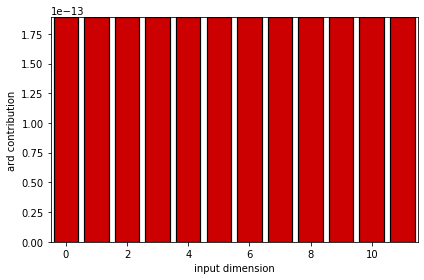

In [0]:
# Plot ARD scales per layer
DGP.obslayer.kern.plot_ARD()
plt.savefig("ard.png")
DGP.layer_1.kern.plot_ARD()
DGP.layer_2.kern.plot_ARD()
DGP.layer_3.kern.plot_ARD()

Text(0.5, 1.0, 'Layer 3')

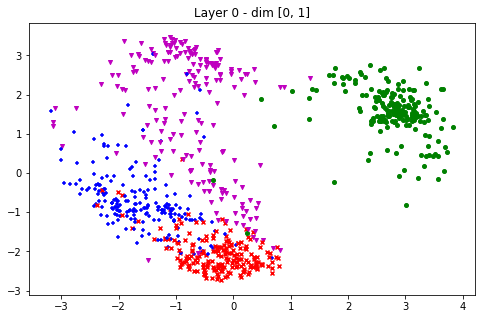

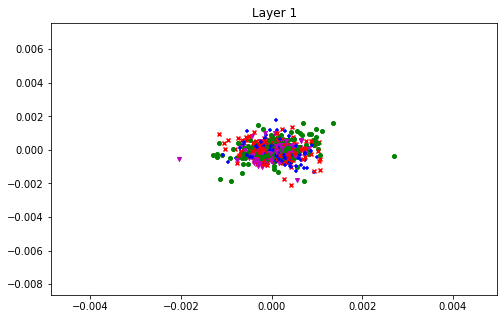

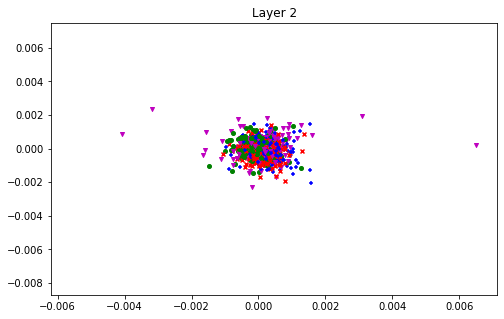

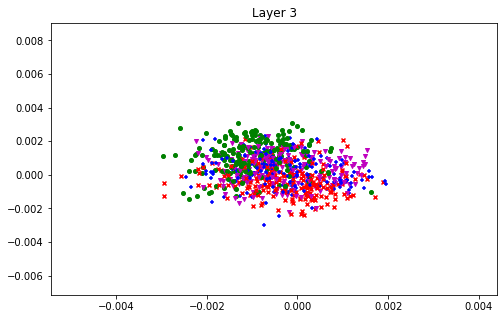

In [0]:
# Latent space visualization
plt.figure(figsize=(8,5))
deepgp.util.visualize_DGP(DGP, y_train, layer=0, dims=[0, 1]); plt.title('Layer 0 - dim [0, 1]')
plt.savefig("embeddings.png")
plt.figure(figsize=(8,5))
deepgp.util.visualize_DGP(DGP, y_train, layer=1, dims=[0,1]); plt.title('Layer 1')
plt.figure(figsize=(8,5))
deepgp.util.visualize_DGP(DGP, y_train, layer=2, dims=[0,1]); plt.title('Layer 2')
plt.figure(figsize=(8,5))
deepgp.util.visualize_DGP(DGP, y_train, layer=3, dims=[0,1]); plt.title('Layer 3')

# Generate samples

<Figure size 432x288 with 0 Axes>

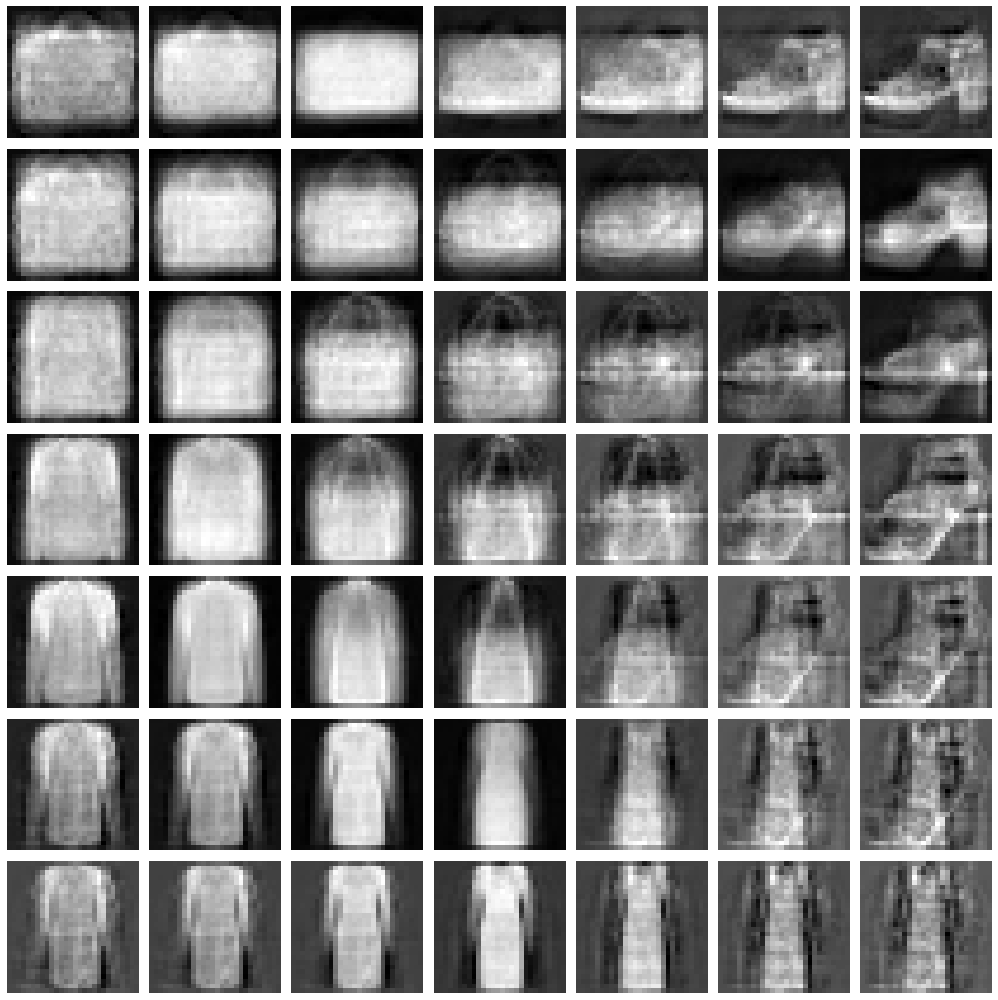

<Figure size 432x288 with 0 Axes>

In [0]:
fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(14, 14))

for i in range(-3, 4):
  for j in range(-3, 4):
    arr = np.zeros((1, 30))
    arr[0, 0] = i
    arr[0, 1] = j
    axes[-j+3,i+3].imshow(DGP.obslayer.predict(arr)[0].reshape((28,28)), cmap='gray')
    axes[-j+3,i+3].axis('off')
fig.tight_layout()
plt.savefig("mosaique.png")
plt.figure()